**Kursarbeit Datenmanagement und -Archivierung WS 23/24**

Master-Code Name-CALICO:MA


**Explorative Datenanalyse**

> Laden Libraries

In [2]:
import pandas as pd
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sklearn
import folium
from folium import plugins
import numpy as np

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive



Verbindung zur Datenbank



In [4]:
#connect to DB
#conn = sqlite3.connect('/content/drive/MyDrive/Datenmanagement_und_Archivierung_im_Umfeld_der_Forschung/CALICO_MA/datawarehouse_new.db')
conn = sqlite3.connect('/content/drive/MyDrive/calico_ma_repo/Data/CALICO_MA_Database/CALICO_MA.db')
#conn = sqlite3.connect('/home/gunnar/DMA2024TeamC/Data/CALICO_MA_Database/CALICO_MA.db')
cur = conn.cursor()

print("Datenbank wurde erfolgreich geöffnet")

Datenbank wurde erfolgreich geöffnet


In [5]:
print(pd.read_sql_query('''
SELECT name FROM sqlite_master
WHERE type='table'
ORDER BY name;
     ''', conn))

            name
0     encounters
1    facts_table
2  immunizations
3    medications
4   observations
5       patients
6     procedures



Die Tabellen werden aus der Datenbank in die DataFrames geladen.




In [6]:
df_encounters = pd.read_sql_query("SELECT * FROM encounters", conn)
df_facts_table = pd.read_sql_query("SELECT * FROM facts_table", conn)
df_immunizations = pd.read_sql_query("SELECT * FROM immunizations", conn)
df_medications = pd.read_sql_query("SELECT * FROM medications", conn)
df_observations = pd.read_sql_query("SELECT * FROM observations", conn)
df_patients = pd.read_sql_query("SELECT * FROM patients", conn)
df_procedures = pd.read_sql_query("SELECT * FROM procedures", conn)

Nur die facts_table Tabelle für die Analyse benötigt.

In [7]:
# Überprüfung der facts_table
df3 = df_facts_table.head(3)
print(df3)

     cancer_type                            patient_ID encounter_ID  \
0  Breast_Cancer  d2061cc7-bee0-0e6c-3ac4-15c197c474e0         None   
1  Breast_Cancer  073d8e80-ff90-1c8d-57e4-29bfca52c87f         None   
2  Breast_Cancer  e1ff7e68-4097-9faf-514d-e4cfcfdf252e         None   

   patient_LAT  patient_LON    patient_COUNTY  patient_ZIP  \
0    42.359926   -71.113260  Middlesex County       2140.0   
1    42.257845   -72.026317  Worcester County       1535.0   
2    42.204290   -71.818449  Worcester County       1545.0   

   patient_HEALTHCARE_EXPENSES  patient_HEALTHCARE_COVERAGE patient_BIRTHDATE  \
0                   1475230.00                      4244.64        1956-06-22   
1                   1489125.00                      4016.36        1964-08-28   
2                     57142.44                      2103.20        1998-08-28   

  observations_CODE  observations_VALUE     observations_DATE  \
0              QALY                63.0  2020-06-22T10:47:46Z   
1          

Anzahl der Tupeln in facts_table:

cancer_type
Breast_Cancer        1011
Colorectal_Cancer    1027
Lung_Cancer          1016
Name: patient_ID, dtype: int64


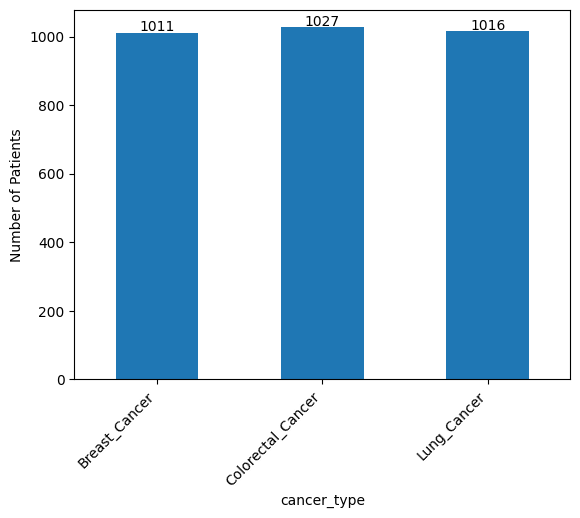

In [8]:
df4 = df_facts_table.groupby(['cancer_type'])['patient_ID'].count()
print(df4)
ax = df4.plot.bar()
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(df4):
    ax.text(i, v + 5, int(v), ha='center')

plt.show()

Abbildungen

1.   Kosten fur jeder krebsarten (Insgesamt)
2.   Kosten fur jeder krebsarten (getrennt)
3.   Life quality (QALY) mit kosten korrelieren (Insgesamt) (death date not available)
4.   Life quality (QALY) mit kosten korrelieren (getrennt)
5.   Verhaltnis QALY - aktuelle alter (von BIRTHDATE (patients))
6.   Statistiche auswertung

# A. Gesamte Kosten für jede Krebsart


## A.1. Einlesen des Life costs und der Cancer costs für jede Krebsart.

Die Life costs bestehen aus den HEALTHCARE EXPENSES und den HEALTHCARE COVERAGE für das ganze Leben, wobei EXPENSES vom Patienten und COVERAGE von der Insurance getragen werden.

Die Cancer Costs bestehen aus der Summe der Kosten, die durch Medications, Procedures und immunizations verursacht worden sind.

In [9]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_HEALTHCARE_EXPENSES as life_expenses,
        f.patient_HEALTHCARE_COVERAGE AS life_coverage,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_costs,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS cancer_costs
        FROM facts_table f
;''')

df_Costs = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'life_expenses', 'life_coverage', 'life_costs', 'cancer_costs'])


## A.2. Darstellung der gesamten Life Kosten (aggregated values, with confidence intervals), d.h. Summe der HEALTHCARE_EXPENSES und HEALTHCARE_COVERAGE, für jede Krebsart.

> Lebzeitkosten für die Die Brustkrebs Patienten sind am höchsten.

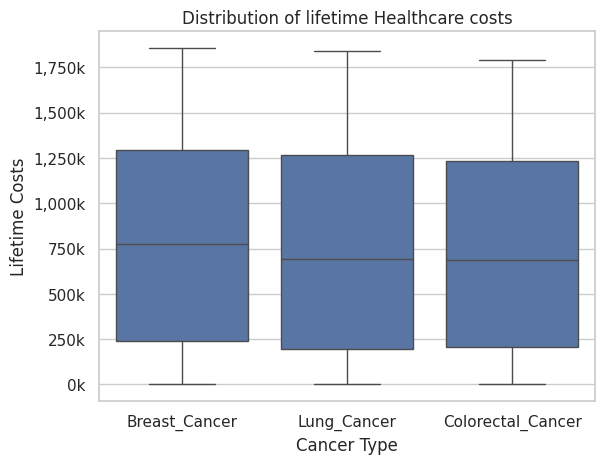

In [10]:
sns.set_theme(style="whitegrid")

g = sns.boxplot(data=df_Costs, x="cancer_type", y="life_costs")
g.set_title("Distribution of lifetime Healthcare costs")
plt.xlabel('Cancer Type')
plt.ylabel('Lifetime Costs')

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Lifetime_costs_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Lifetime_costs_for_all.png", format='png')

## A.3. Darstellung der HEALTHCARE_EXPENSES (aggregated values, with confidence intervals) für jede Krebsart.

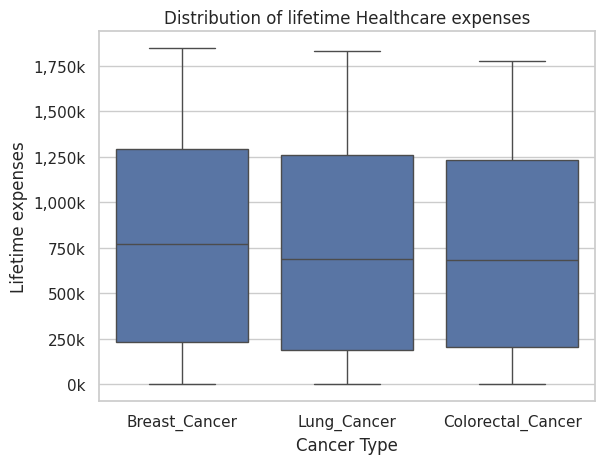

In [11]:
sns.set_theme(style="whitegrid")

g = sns.boxplot(data=df_Costs, x="cancer_type", y="life_expenses")
g.set_title("Distribution of lifetime Healthcare expenses")
plt.xlabel('Cancer Type')
plt.ylabel('Lifetime expenses')

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_expenses_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Lifetime_costs_for_all.png", format='png')

## A.4. Darstellung der HEALTHCARE_COVERAGE (aggregated values, with confidence intervals) für jede Krebsart.

> Die Kosten, die von der Insurance übernommen worden sind, sind viel niedriger als diejenigen, die vom Patienten bezahlt worden sind.

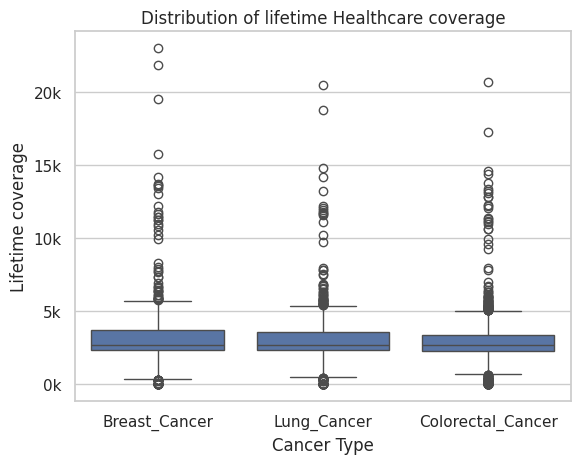

In [12]:
sns.set_theme(style="whitegrid")

g = sns.boxplot(data=df_Costs, x="cancer_type", y="life_coverage")
g.set_title("Distribution of lifetime Healthcare coverage")
plt.xlabel('Cancer Type')
plt.ylabel('Lifetime coverage')

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_coverage_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Life_coverage_for_all.png", format='png')



Ein schneller Test mit der IQR (interquartile range) Methode

In [13]:
# Calculate Q1, Q3, and IQR
Q1 = df_Costs['life_coverage'].quantile(0.25)
Q3 = df_Costs['life_coverage'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df_Costs[(df_Costs['life_coverage'] < Q1 - 1.5*IQR) | (df_Costs['life_coverage'] > Q3 + 1.5*IQR)]

print("Number of outliers:", len(outliers))
print("Outliers:")
print(outliers)

Number of outliers: 346
Outliers:
            cancer_type  life_expenses  life_coverage  life_costs  \
12        Breast_Cancer        3745.64           0.00     3745.64   
14        Breast_Cancer     1623235.00        5822.84  1629057.84   
18        Breast_Cancer       32909.74         444.96    33354.70   
26        Breast_Cancer        2712.36           0.00     2712.36   
45        Breast_Cancer     1315197.72       10202.88  1325400.60   
...                 ...            ...            ...         ...   
2993  Colorectal_Cancer     1666640.00        5707.76  1672347.76   
3007  Colorectal_Cancer     1635250.00        6315.24  1641565.24   
3023  Colorectal_Cancer      307287.37        5829.48   313116.85   
3044  Colorectal_Cancer        5967.18           0.00     5967.18   
3051  Colorectal_Cancer      113125.65        9621.89   122747.54   

      cancer_costs  
12         2449.84  
14       421351.84  
18         1348.40  
26         3961.48  
45         3107.00  
...        

Ein schneller Test mit der IQR (interquartile range) Methode

## A.5. Darstellung der gesamten Cancer Kostenverteilung (aggregated values, with confidence intervals). Es ist die Summe der Kosten, die durch Medications, Procedures und immunizations verursacht worden sind.

> Die höchsten Kosten findet man bei den Colorectal Cancer patients.

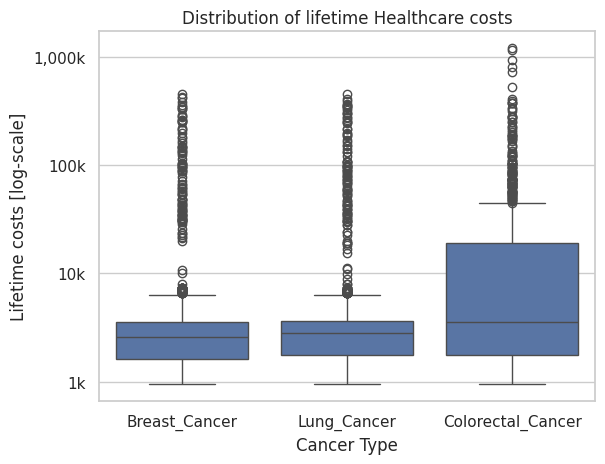

In [14]:
sns.set_theme(style="whitegrid")

g = sns.boxplot(data=df_Costs, x="cancer_type", y="cancer_costs")
g.set_title("Distribution of lifetime Healthcare costs")
plt.xlabel('Cancer Type')
plt.ylabel('Lifetime costs [log-scale]')

# Set y-axis to logarithmic scale
g.set_yscale("log")

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("//content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_for_all.png", format='png')

Ein schneller Test mit der IQR (interquartile range) Methode

In [15]:
# Calculate Q1, Q3, and IQR
Q1 = df_Costs['cancer_costs'].quantile(0.25)
Q3 = df_Costs['cancer_costs'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df_Costs[(df_Costs['cancer_costs'] < Q1 - 1.5*IQR) | (df_Costs['cancer_costs'] > Q3 + 1.5*IQR)]

print("Number of outliers:", len(outliers))
print("Outliers:")
print(outliers)

Number of outliers: 505
Outliers:
            cancer_type  life_expenses  life_coverage  life_costs  \
14        Breast_Cancer     1623235.00        5822.84  1629057.84   
23        Breast_Cancer       98706.48        2826.40   101532.88   
24        Breast_Cancer     1409750.00        4103.80  1413853.80   
27        Breast_Cancer     1097307.42        2870.60  1100178.02   
33        Breast_Cancer      427338.18        2769.84   430108.02   
...                 ...            ...            ...         ...   
3040  Colorectal_Cancer       18710.00        1264.55    19974.55   
3044  Colorectal_Cancer        5967.18           0.00     5967.18   
3046  Colorectal_Cancer     1442870.00        3813.04  1446683.04   
3051  Colorectal_Cancer      113125.65        9621.89   122747.54   
3052  Colorectal_Cancer      231267.49        5119.56   236387.05   

      cancer_costs  
14       421351.84  
23        23823.67  
24       198125.95  
27        45063.68  
33        31068.25  
...        

## A.6. Berechnung der QALY Werte für alle Krebsarten

Die qualitätsadjustierten Lebensjahre (QALYs, engl. = Quality-Adjusted Life Years) erscheinen als "QALY" in den Quelldateien und werden unter dem Attribut "observations_VALUE" in der Faktentabelle gespeichert.

Die qualitätsadjustierten Lebensjahre einer Person werden bestimmt, indem man die erwartete Dauer jedes Gesundheitszustandes mit dem Nutzwert dieses Zustandes gewichtet. Das eigentliche QALY bewegt sich in einem Skalenbereich von 1 bis 0, wobei ein QALY von 1 ein Jahr in voller Gesundheit bedeutet, während ein QALY von 0 dem Tod entspricht.

Für unsere Analyse wird QALY als Verhältnis zwischen "observations_VALUE" und Alter zum Zeitpunkt der Observation "observations_AGE" berechnet und in die Variable "QALY_Wert" gespeichert. Im ETL wurde dafür gesorgt, dass die Faktentabelle nur strikt positive Werte von "observations_AGE" enthält.

In [16]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
;''')


df_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
df3 = df_QALY.head(3)
print(df3)



     cancer_type        LAT        LON  QALY   Age  Value  QALY_Wert  \
0  Breast_Cancer  42.359926 -71.113260  QALY  64.0   63.0   0.984375   
1  Breast_Cancer  42.257845 -72.026317  QALY  56.0   55.0   0.982143   
2  Breast_Cancer  42.204290 -71.818449  QALY  22.0   21.0   0.954545   

   life_costs  cancer_costs  
0  1479474.64       7069.03  
1  1493141.36       2579.00  
2    59245.64       2860.04  


## A.7. Frequenz der QALY Werte in dem Datensatz

Die Darstellung der Anzahl an vorhandenen QALY Werten für jede Krebsart zeigt eine sehr inhomogene Verteilung der Daten. Die meisten Daten bewegen sich in dem Bereich von 0,9 bis 1,0.

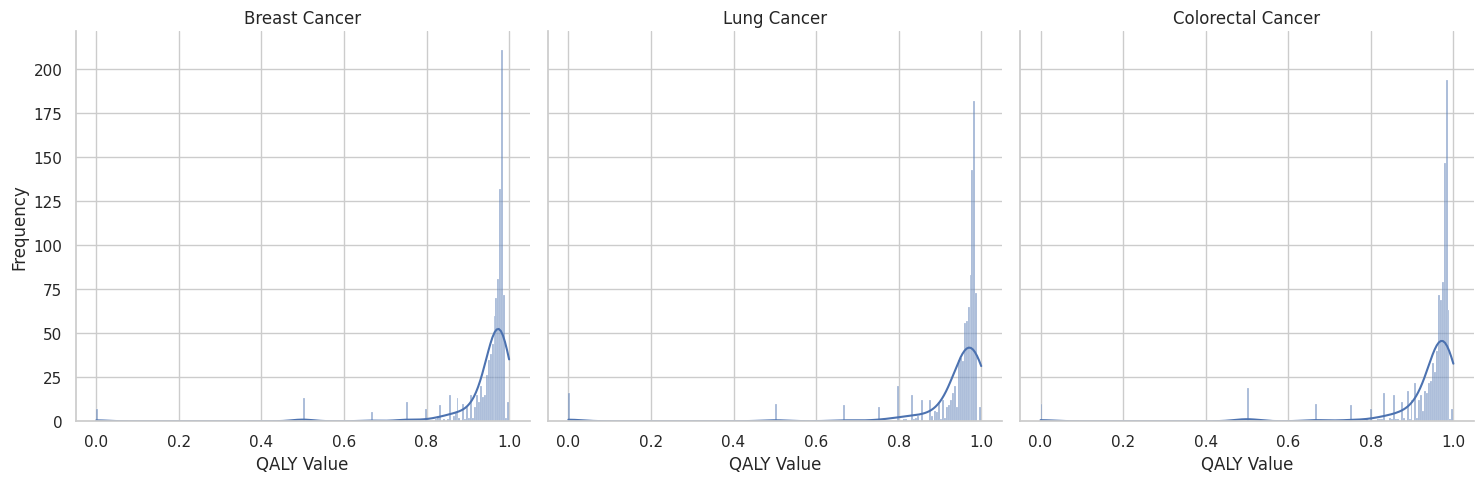

In [17]:
sns.set_theme(style="whitegrid")

g = sns.displot(data=df_QALY, x="QALY_Wert", col="cancer_type", kind="hist", kde=True)

# Set individual titles
for ax in g.axes.flat:
    title = ax.get_title().split('=')[1].strip()
    ax.set_title(title.replace('_', ' '))

# Set x and y axis labels
g.set_axis_labels('QALY Value', 'Frequency')

plt.savefig("//content/drive/MyDrive/calico_ma_repo/Documentation/QALY_Datensatz_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/QALY_Datensatz_for_all.png", format='png')

## A.8. Altersverteilung im Datensatz

<ipython-input-18-eee028df2717>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels)


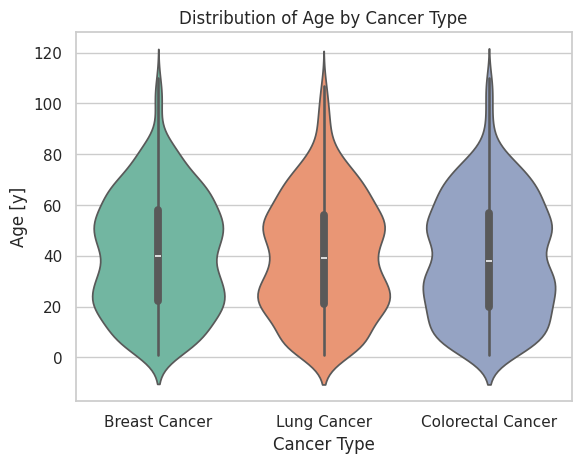

In [18]:
sns.set_theme(style="whitegrid")

# Use a color palette
g = sns.violinplot(data=df_QALY, x="cancer_type", y="Age", hue="cancer_type", palette='Set2', legend=False)
g.set_title("Distribution of Age by Cancer Type")
plt.xlabel('Cancer Type')
plt.ylabel('Age [y]')

# Replace underscore in x-axis labels
labels = [label.get_text().replace('_', ' ') for label in g.get_xticklabels()]
g.set_xticklabels(labels)

plt.savefig("//content/drive/MyDrive/calico_ma_repo/Documentation/Alter_Datensatz_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Alter_Datensatz_for_all.png", format='png')

## A.9. Gesamte Geografische Verteilung

Darstellung mit folium der gesamte geografischen Verteilung. Der Wohnungsort jedes Patienten wird auf der Karte von Massachusetts mit Hilfe seiner LAT und LON Koordinaten eingetragen.

In [19]:
MASSA_COORDINATES =(42.407211, -71.382439)
map_massa = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_p = df_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_p)):
    folium.RegularPolygonMarker(coordinates_p[i], radius = 1, fill_color = "red", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa)
map_massa


## A.10. Cancer costs vs. Age

Die Cancer Kosten erhöhen sich ab ca. 60 Jahre für alle Krebsarten.

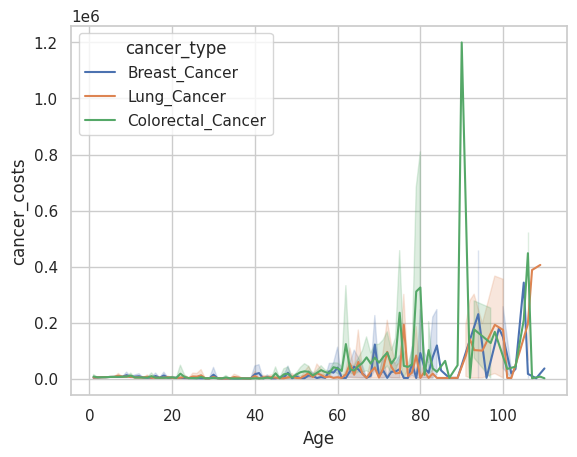

In [20]:
sns.set_theme(style="whitegrid")

g = sns.lineplot(
    data=df_QALY, x="Age", y="cancer_costs", hue="cancer_type")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_age.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_vs_age.png", format='png')

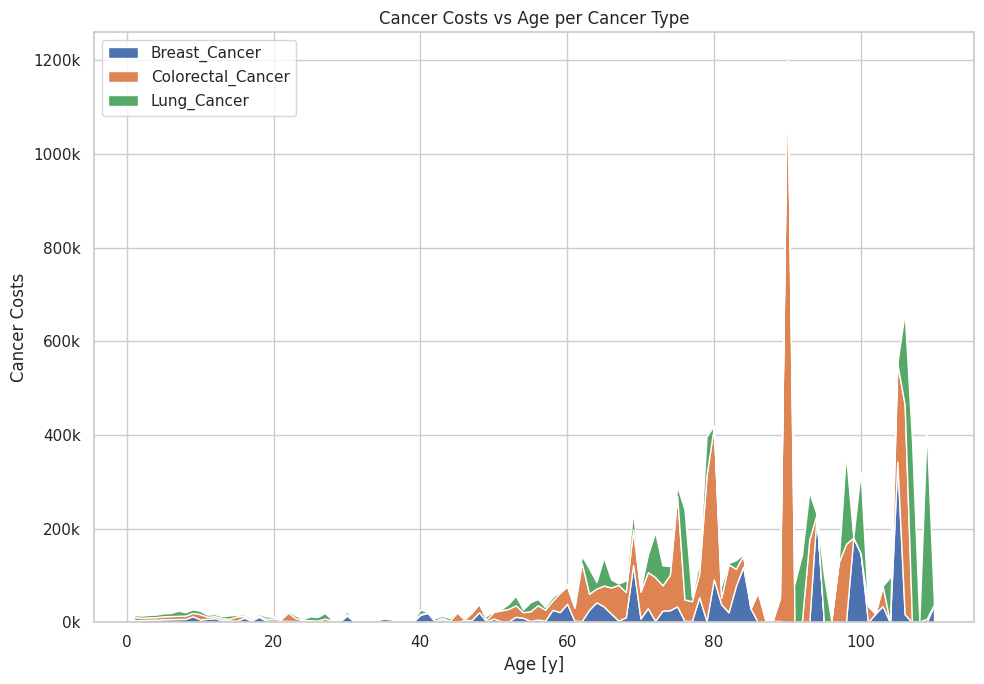

In [21]:
# Function to format y-axis tick values
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Reshape the data
df_pivot = df_QALY.pivot_table(index='Age', columns='cancer_type', values='cancer_costs', fill_value=0)

# Create a stacked area plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(df_pivot.index, df_pivot.T, labels=df_pivot.columns)
ax.legend(loc='upper left')
ax.set_title('Cancer Costs vs Age per Cancer Type')
ax.set_xlabel('Age [y]')
ax.set_ylabel('Cancer Costs')
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_age.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_vs_age.png", format='png')

## A.11. LIFE HEALTHCARE Kosten vs. Alter

Die gesamte Life Healthcare Kosten steigen mit dem Alter.

Es gibt zwei Bereiche: ein mit niedrigen Kosten und ein mit hohen Kosten.

Beide zeigen eine lineare Abhängigkeit mit dem Alter.

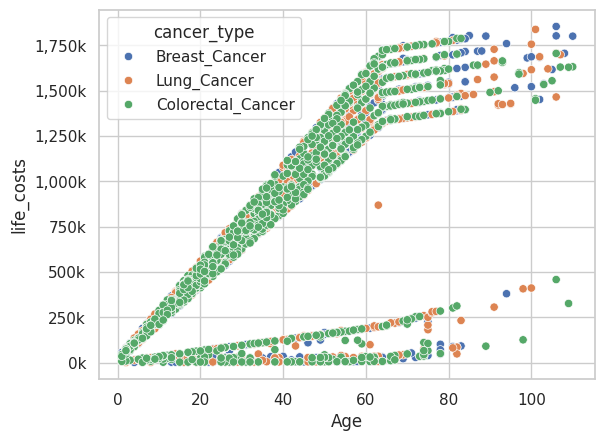

In [22]:
g = sns.scatterplot(
    data=df_QALY, x="Age", y="life_costs", hue="cancer_type")

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_age.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Life_costs_vs_age.png", format='png')

## A.12. Cancer costs vs. QALY

Höhere Cancer costs sind mit höheren QALY Werte verbunden.

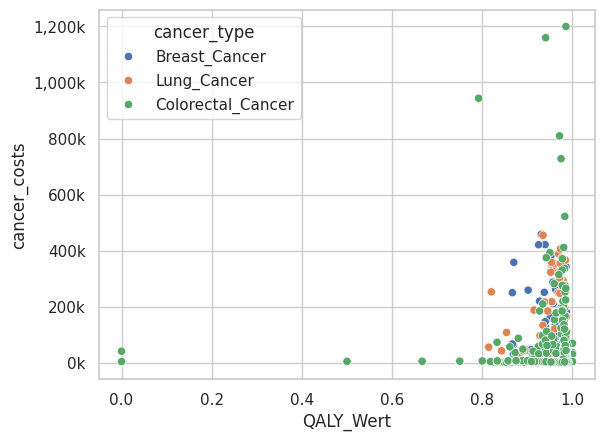

In [23]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_QALY, x="QALY_Wert",y="cancer_costs", hue="cancer_type")

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_vs_QALY.png", format='png')

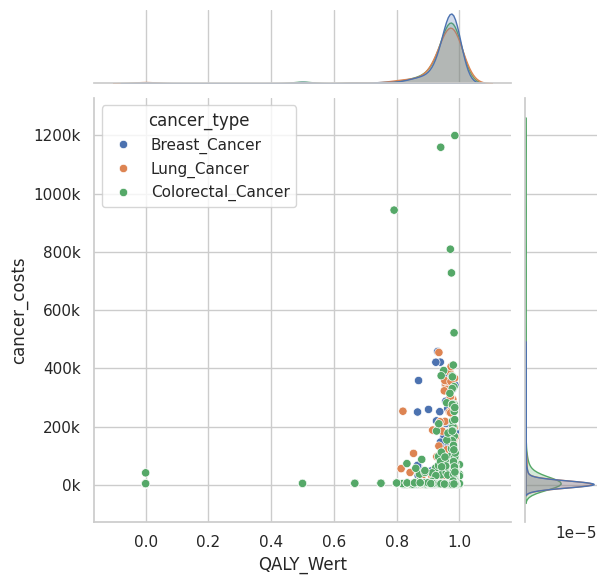

In [24]:
# Function to format y-axis tick values
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Create a joint plot with larger marginal charts
g = sns.jointplot(data=df_QALY, x="QALY_Wert", y="cancer_costs", hue="cancer_type")

# Format y-axis labels
g.ax_joint.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_vs_QALY.png", format='png')

## A.13. Life HEALTHCARE Kosten vs. QALY

Höhere Life HEALTHCARE Kosten sind mit höheren QALY Werte verbunden.

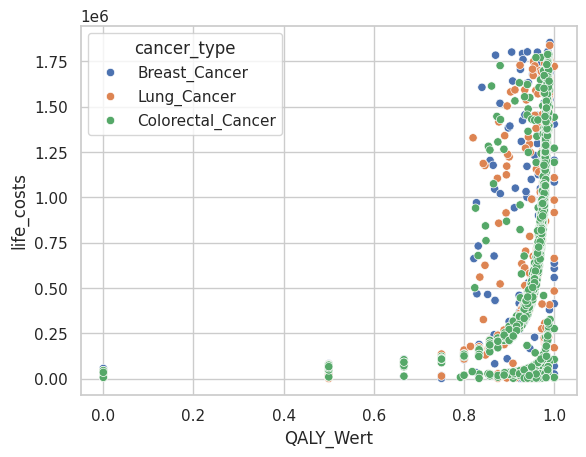

In [25]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_QALY, x="QALY_Wert",y="life_costs", hue="cancer_type")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Life_costs_vs_QALY.png", format='png')

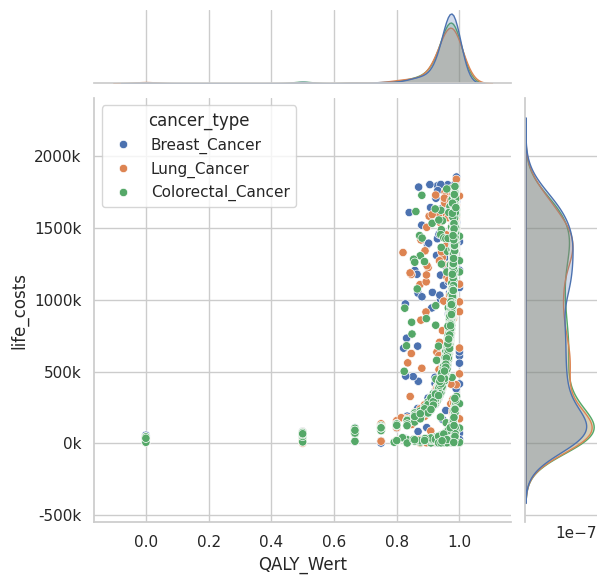

In [26]:
# Function to format y-axis tick values
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Create a joint plot with larger marginal charts
g = sns.jointplot(data=df_QALY, x="QALY_Wert", y="life_costs", hue="cancer_type")

# Format y-axis labels
g.ax_joint.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Life_costs_vs_QALY.png", format='png')

# B. Lungenkrebs Patients

## B.1. Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Lungenkrebs Patienten

In [27]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.cancer_type LIKE "Lung_Cancer"
;''')

df_lung_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
#result = df_lung.head(50)
#print(result)




## B.2. Geografische Verteilung der Lungenkrebs Patienten

Darstellung mit folium der geografischen Verteilung der Lung Cancer Patienten. Der Wohnungsort jedes Patienten wird auf der Karte von Massachusetts mit Hilfe seiner LAT und LON Koordinaten eingetragen.

In [28]:
MASSA_COORDINATES =(42.407211, -71.382439)
map_massa_lung = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_lung = df_lung_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_lung)):
    folium.RegularPolygonMarker(coordinates_lung[i], radius = 3, fill_color = "red", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa_lung)
map_massa_lung

## B.3. Verteilung der vorhandenen QALY Werte bei Lungenkrebs Patienten

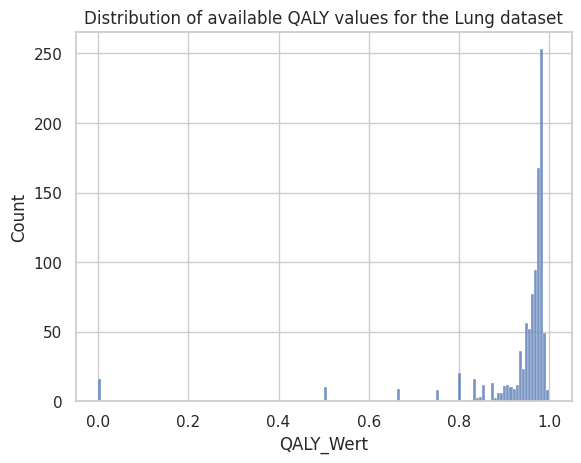

In [29]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_lung_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Lung dataset")

## B.4. Cancer Kosten als Funktion vom QALY für Lungenkrebs Patienten

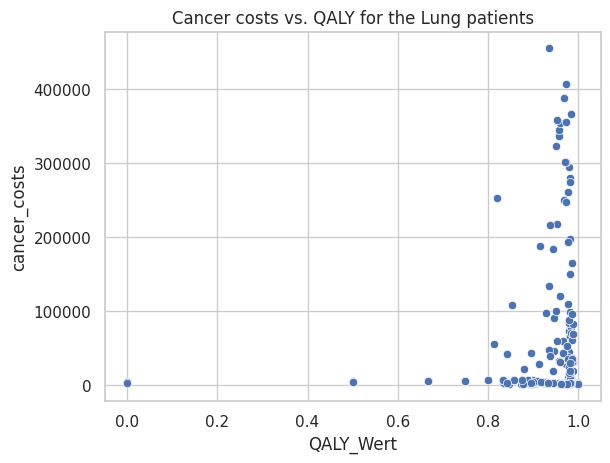

In [30]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_lung_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Lung patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY_Lung.png", format='png')


## B.5. Life Healthcare Kosten als Funktion vom QALY für Lungenkrebs Patienten

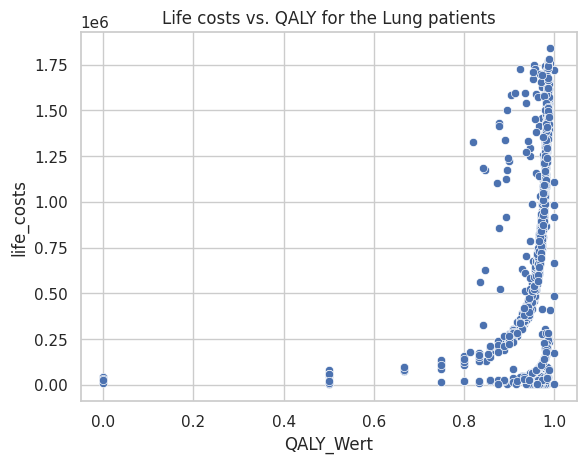

In [31]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_lung_QALY, x="QALY_Wert",y="life_costs"
).set_title("Life costs vs. QALY for the Lung patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY_Lung.png", format='png')

# C. Darmbrebs patients

## C.1. Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Darmkrebs Patienten

In [32]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.cancer_type LIKE "Colorectal_Cancer"
;''')

df_colorectal_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
result = df_colorectal_QALY.head(5)
print(result)

         cancer_type        LAT        LON  QALY   Age  Value  QALY_Wert  \
0  Colorectal_Cancer  42.260377 -72.582313  QALY  37.0   36.0   0.972973   
1  Colorectal_Cancer  42.296278 -71.052652  QALY  39.0   38.0   0.974359   
2  Colorectal_Cancer  41.753744 -71.098516  QALY  35.0   34.0   0.971429   
3  Colorectal_Cancer  42.405090 -72.554248  QALY  52.0   51.0   0.980769   
4  Colorectal_Cancer  42.656468 -71.160367  QALY  51.0   50.0   0.980392   

   life_costs  cancer_costs  
0   904391.44       1219.24  
1   811891.44        949.56  
2   721662.28       1219.24  
3    18674.72       2039.64  
4  1114095.56       2320.68  


## C.2. Geografische Verteilung der Darmkrebs Patienten

In [33]:
map_massa_colorectal = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_colorectal = df_colorectal_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_colorectal)):
    folium.RegularPolygonMarker(coordinates_colorectal[i], radius = 3, fill_color = "blue", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa_colorectal)
map_massa_colorectal

## C.3. Verteilung der vorhandenen QALY Werte im Datensatz bei Darmkrebs Patienten

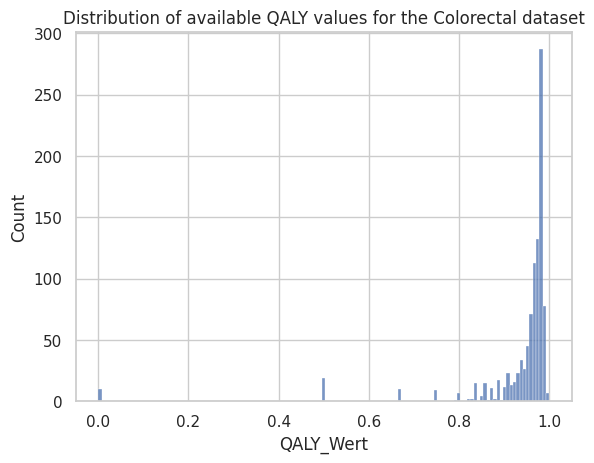

In [34]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_colorectal_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Colorectal dataset")

## C.4. Cancer Kosten als Funktion vom QALY für Darmkrebs Patienten

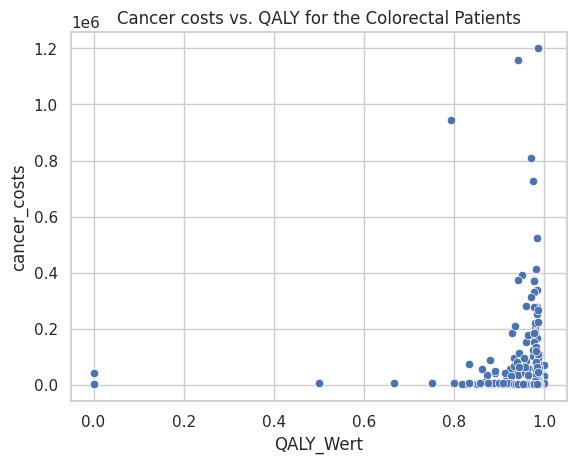

In [35]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_colorectal_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Colorectal Patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY_Colorectal.png", format='png')

## C.5. Life HEALTHCARE Kosten als Funktion vom QALY für Darmkrebs Patienten

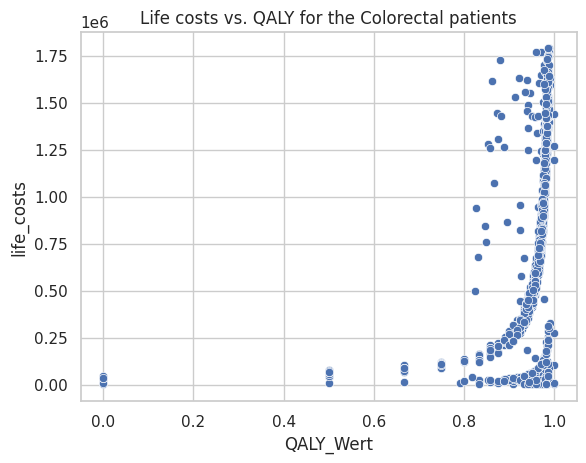

In [36]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_colorectal_QALY, x="QALY_Wert",y="life_costs"
).set_title("Life costs vs. QALY for the Colorectal patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY_Colorectal.png", format='png')

# D. Brustkrebs Patienten

## D.1. Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Brustkrebs Patienten

In [37]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.cancer_type LIKE "Breast_Cancer"
;''')

df_breast_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
result = df_breast_QALY.head(5)
print(result)

     cancer_type        LAT        LON  QALY   Age  Value  QALY_Wert  \
0  Breast_Cancer  42.359926 -71.113260  QALY  64.0   63.0   0.984375   
1  Breast_Cancer  42.257845 -72.026317  QALY  56.0   55.0   0.982143   
2  Breast_Cancer  42.204290 -71.818449  QALY  22.0   21.0   0.954545   
3  Breast_Cancer  42.150270 -70.904084  QALY  16.0   15.0   0.937500   
4  Breast_Cancer  42.292082 -71.784873  QALY  14.0   13.0   0.928571   

   life_costs  cancer_costs  
0  1479474.64       7069.03  
1  1493141.36       2579.00  
2    59245.64       2860.04  
3   411229.00       3539.92  
4   323370.68       3961.48  


## D.2. Geografische Verteilung der Brustkrebs Patienten

In [38]:
map_massa_breast = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_breast = df_breast_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_breast)):
    folium.RegularPolygonMarker(coordinates_breast[i], radius = 3, fill_color = "green", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa_breast)
map_massa_breast

## D.3. Verteilung der vorhandenen QALY Werte im Datensatz bei Brustkrebs Patienten

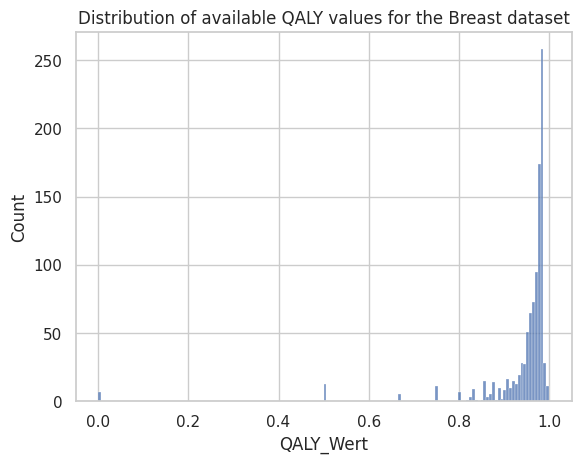

In [39]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_breast_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Breast dataset")

## D.4. Cancer Kosten vs. QALY Werte für Brustkrebs Patienten

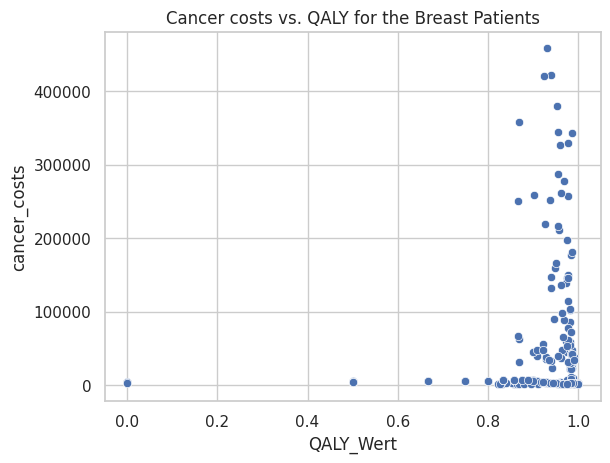

In [40]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_breast_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Breast Patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY_Breast.png", format='png')

## D.5. Life HEALTHCARE Kosten als Funktion vom QALY für Breast Patienten

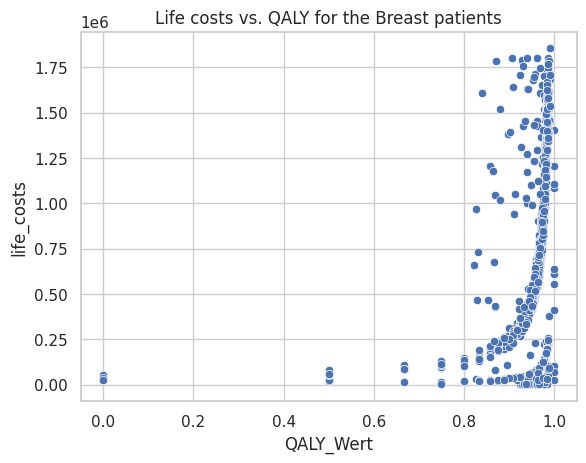

In [41]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_breast_QALY, x="QALY_Wert",y="life_costs"
).set_title("Life costs vs. QALY for the Breast patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY_Breast.png", format='png')

## Statistische Auswertung

In [45]:
# Gibt es signifikante Unterschiede in den krebsspezifischen und den lebenslangen Kosten?
# Vergleich dreier Gruppe, um die Voraussetzungen für einen parametrischen Test wie die einfaktorielle Varianzanalyse zu testen, muss die Frage nach
# Varianzhomogenität mittels Levene-Test und Normalverteilung mittels Shapiro-Wilk-Test in den Daten beantwortet werden.

In [46]:
from scipy.stats import shapiro
from scipy.stats import levene

In [48]:
# Lebenskosten nach Krebs normalverteilt?
statistic, p_value = shapiro(df_Costs['life_costs'])

# Ergebnisse anzeigen
print("Teststatistik:", statistic)
print("p-Wert:", p_value)

# Interpretation des p-Werts
alpha = 0.05
if p_value > alpha:
    print("Die Daten könnten normalverteilt sein (p > 0.05)")
else:
    print("Die Daten sind nicht normalverteilt (p ≤ 0.05)")

Teststatistik: 0.9274706840515137
p-Wert: 4.0678780548542945e-36
Die Daten sind nicht normalverteilt (p ≤ 0.05)


In [49]:
# Krebskosten normalverteilt?
statistic, p_value = shapiro(df_Costs['cancer_costs'])

# Ergebnisse anzeigen
print("Teststatistik:", statistic)
print("p-Wert:", p_value)

# Interpretation des p-Werts
alpha = 0.05
if p_value > alpha:
    print("Die Daten könnten normalverteilt sein (p > 0.05)")
else:
    print("Die Daten sind nicht normalverteilt (p ≤ 0.05)")

Teststatistik: 0.2721339464187622
p-Wert: 0.0
Die Daten sind nicht normalverteilt (p ≤ 0.05)


In [51]:
# Lebenskosten nach Krebs mit Homoskedastizität bzw. Varianzhomogenität?
groups = df_Costs['cancer_type'].unique()
grouped_data = [df_Costs[df_Costs['cancer_type'] == group]['life_costs'] for group in groups]
statistic, p_value = levene(*grouped_data)

# Ergebnisse anzeigen
print("Teststatistik:", statistic)
print("p-Wert:", p_value)

# Interpretation des p-Werts
alpha = 0.05
if p_value > alpha:
    print("Die Varianzen könnten homogen sein (p > 0.05)")
else:
    print("Die Varianzen sind nicht homogen (p ≤ 0.05)")

Teststatistik: 0.20860105402658746
p-Wert: 0.8117305791239051
Die Varianzen könnten homogen sein (p > 0.05)


In [52]:
# Krebskosten mit Homoskedastizität bzw. Varianzhomogenität?
groups = df_Costs['cancer_type'].unique()
grouped_data = [df_Costs[df_Costs['cancer_type'] == group]['cancer_costs'] for group in groups]
statistic, p_value = levene(*grouped_data)

# Ergebnisse anzeigen
print("Teststatistik:", statistic)
print("p-Wert:", p_value)

# Interpretation des p-Werts
alpha = 0.05
if p_value > alpha:
    print("Die Varianzen könnten homogen sein (p > 0.05)")
else:
    print("Die Varianzen sind nicht homogen (p ≤ 0.05)")

Teststatistik: 11.890086478682367
p-Wert: 7.181596371177688e-06
Die Varianzen sind nicht homogen (p ≤ 0.05)


In [53]:
# Die Voraussetzungen für einen parametrischen Test sind nicht erfüllt, sodass wir die nicht parametrische Alternative des Kruskal-Wallis-Test benutzen um einen
# Gruppenvergleich zwischen den Kosten für die drei malignen Entitäten durchzuführen.

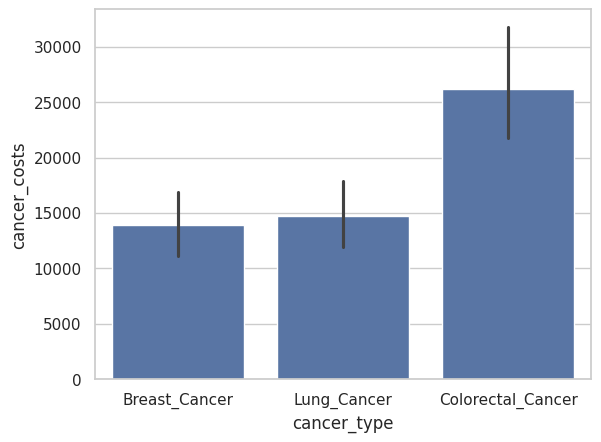

In [57]:
# Zur erneuten Visualisierung der Krebskosten für jede einzelne Krebsart
sns.barplot(data=df_Costs, x="cancer_type", y="cancer_costs");

In [54]:
## Kruskal-Wallis Test
from scipy.stats import kruskal
# Gruppieren der Daten nach 'cancer_type'
grouped_data = [df_Costs[df_Costs['cancer_type'] == cancer]['cancer_costs'] for cancer in df_Costs['cancer_type'].unique()]

# Kruskal-Wallis-Test
kw_statistic, p_value = kruskal(*grouped_data)

# Ergebnisse anzeigen
print("Kruskal-Wallis-Statistik:", kw_statistic)
print("P-Wert:", p_value)

Kruskal-Wallis-Statistik: 65.43136349800201
P-Wert: 6.19098775032979e-15


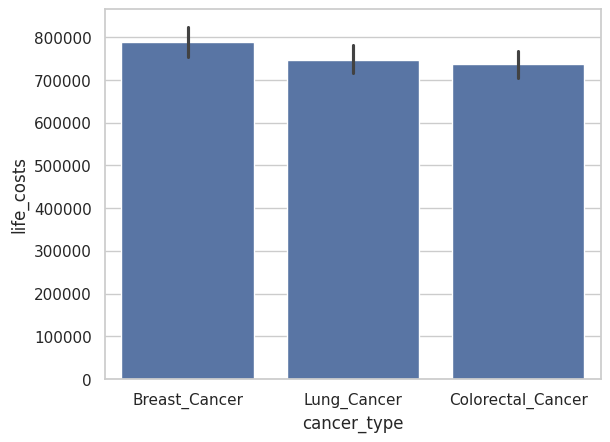

In [58]:
# Zur erneuten Visualisierung der lebenslangen Kosten für jede einzelne Krebsart
sns.barplot(data=df_Costs, x="cancer_type", y="life_costs");

In [55]:
# Gruppieren der Daten nach 'cancer_type'
grouped_data = [df_Costs[df_Costs['cancer_type'] == cancer]['life_costs'] for cancer in df_Costs['cancer_type'].unique()]

# Kruskal-Wallis-Test
kw_statistic, p_value = kruskal(*grouped_data)

# Ergebnisse anzeigen
print("Kruskal-Wallis-Statistik:", kw_statistic)
print("P-Wert:", p_value)

Kruskal-Wallis-Statistik: 4.8332603304432
P-Wert: 0.08922177407350836


In [62]:
# Wir sehen einen signifikanten Unterschied zwischen den drei Krebsentitäten in Bezug auf die Krebskosten. Daher muss nun ein Post-Hoc Test durchgeführt werden,
# um die konkreten Unterschiede zwischen den einzelnen Gruppen festzustellen. Wir benutzen in der Situation den Conover-Test.

# Falls noch nicht installiert
# !pip install scikit-posthocs

import scikit_posthocs as sp
# Durchführung des Conover-Tests
conover_results = sp.posthoc_conover(df_Costs, val_col='cancer_costs', group_col='cancer_type')

# Anzeigen der Ergebnisse
print(conover_results)

                   Breast_Cancer  Colorectal_Cancer   Lung_Cancer
Breast_Cancer       1.000000e+00       7.644500e-14  3.238043e-01
Colorectal_Cancer   7.644500e-14       1.000000e+00  7.679864e-11
Lung_Cancer         3.238043e-01       7.679864e-11  1.000000e+00


In [ ]:
# Wir können die konkrete Aussage treffen, dass die krebsspezifischen Kosten für Darmkrebs signifikant höher ausfallen, als für Brust-oder Lungenkrebs. Einen Unterschied
# zwischen den lebenslangen Kosten gibt es hingegen nicht.

### Gibt es eine Korrelation zwischen der Lebensqualität und den Ausgaben? Mit anderen Worten, sind höhere Kosten auch mit einer besseren Lebensqualität korreliert?

In [71]:
# Dataframe mit allen Spalten, um Korrelation zwischen den beiden Zielvariablen bzw. den Krebs-und den lebenslangen Kosten mit der Lebensqualität zu berechnen
df_corr = df_facts_table[['patient_HEALTHCARE_EXPENSES', 'patient_HEALTHCARE_COVERAGE', 'observations_VALUE', 'observations_AGE', 'procedures_BASE_COST',
                          'medications_TOTALCOST', 'immunizations_BASE_COST', 'encounter_BASE_ENCOUNTER_COST']].copy()

df_corr['life_cost'] = df_corr["patient_HEALTHCARE_EXPENSES"] + df_corr['patient_HEALTHCARE_COVERAGE']
df_corr['cancer_cost'] = df_corr["procedures_BASE_COST"] + df_corr['medications_TOTALCOST'] + df_corr["immunizations_BASE_COST"] + df_corr['encounter_BASE_ENCOUNTER_COST']

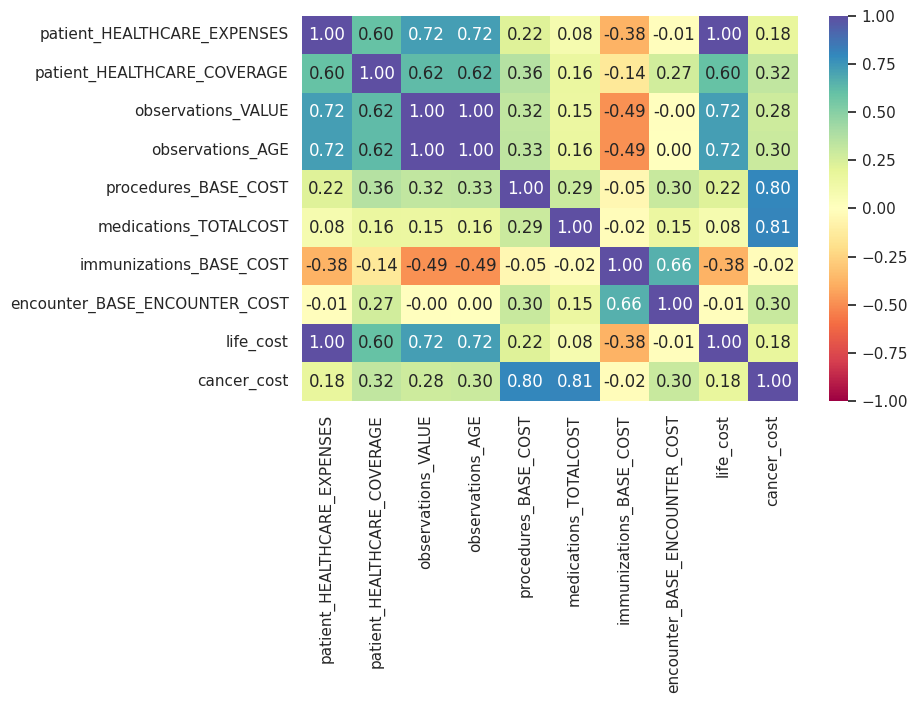

In [73]:
# to plot the heat map
plt.figure(figsize=(8, 5))
sns.heatmap(df_corr.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral");
#plt.show()

In [ ]:
## Wir sehen, dass eine höhere Lebensqualität eindeutig mit höheren Lebenszeitkosten korreliert ist. Hingegen sind die spezifischen Krebskosten nur
# schwach korreliert mit der Lebensqualität.

## Machine Learning

In [91]:
# Dataframe erstellen mit den notwendigen Variablen um die Zielvariablen life_cost und cancer_cost vorherzusagen

df_ml = df_facts_table[['cancer_type', 'patient_COUNTY', 'patient_HEALTHCARE_EXPENSES', 'patient_HEALTHCARE_COVERAGE', 'observations_AGE', 'procedures_BASE_COST',
                          'medications_TOTALCOST', 'immunizations_BASE_COST', 'encounter_BASE_ENCOUNTER_COST']].copy()

df_ml['life_cost'] = df_ml["patient_HEALTHCARE_EXPENSES"] + df_ml['patient_HEALTHCARE_COVERAGE']
df_ml['cancer_cost'] = df_ml["procedures_BASE_COST"] + df_ml['medications_TOTALCOST'] + df_ml["immunizations_BASE_COST"] + df_ml['encounter_BASE_ENCOUNTER_COST']

ml = df_ml[['cancer_type', 'patient_COUNTY', 'observations_AGE', 'life_cost', 'cancer_cost']]

In [92]:
# Unterdrücken der SettingWithCopyWarning-Warnungen
pd.set_option('mode.chained_assignment', None)

# Typecasting für die Dummy-Codierung
ml['cancer_type'] = ml['cancer_type'].astype('category')
ml['patient_COUNTY'] = ml['patient_COUNTY'].astype('category')

# Wiederherstellen der Standardwarnungen
pd.reset_option('mode.chained_assignment')

In [94]:
# Da wir zwei Counties mit weniger als 10 Werten haben, werden diese für das Erstellen des ML-Modells ausgeschlossen
value_counts = ml['patient_COUNTY'].value_counts()

# Werte mit weniger als 10 Auftreten filtern
values_to_remove = value_counts[value_counts < 10].index

# Zeilen mit diesen Werten löschen
ml = ml[~ml['patient_COUNTY'].isin(values_to_remove)]

In [96]:
# Kategoriale Variablen dummycodieren, damit sie als Einflussvariablen im Modell genutzt werden können
df_machine_learning = pd.get_dummies(ml, columns=['cancer_type', 'patient_COUNTY'], drop_first=True)

Ab hier müssen wir für die zwei zu vorhersagenden Variablen "cancer_cost" und " life_cost" jeweils zwei Modelle erstellen

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, linear_model
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [100]:
##  Funktion um wichtige Güteparameter zu berechnen
def get_model_score(model, flag=True):

    score_list=[]

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_r2=metrics.r2_score(y_train,pred_train)
    test_r2=metrics.r2_score(y_test,pred_test)
    train_rmse=np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_test))

    # Alle Ergebnisse in eine Liste
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse))

    if flag==True:
        print("R-sqaure on training set : ",metrics.r2_score(y_train,pred_train))
        print("R-square on test set : ",metrics.r2_score(y_test,pred_test))
        print("RMSE on training set : ",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
        print("RMSE on test set : ",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))

    return score_list

### Lineare Regression

#### Lebenslange Kosten

In [148]:
# Unabhängige Variables
X = df_machine_learning.drop(['life_cost', 'cancer_cost'], axis=1)
# Abhängige Variable
y = df_machine_learning[['life_cost']]

# Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
# Da fehlende Werte für das Alter in der Tabelle bestehen, müssen diese imputet werden. Aufgrund der synthetischen Daten und dem wahrscheinlich fehlendem
# Zusammenhang nutzen wir den einfachsten Algorithmus und füllen die Werte mit dem Mittelwert aus den jeweiligen Teildatensätzen.
X_train['observations_AGE'] = X_train['observations_AGE'].fillna(X_train['observations_AGE'].mean())
X_test['observations_AGE'] = X_test['observations_AGE'].fillna(X_test['observations_AGE'].mean())

In [150]:
# Lineares Regressionsmodell aus den Trainigsdaten erstellen
model_life_cost = LinearRegression()
model_life_cost.fit(X_train, y_train)

LinearRegression()

In [152]:
# Die einzelnen Koeffizienten und den Intercept bestimmen
coef_df = pd.DataFrame(
    np.append(model_life_cost.coef_, model_life_cost.intercept_),
    index=X_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df

Coefficients
observations_AGE                 1.745847e+04
cancer_type_Colorectal_Cancer   -9.024327e+03
cancer_type_Lung_Cancer         -2.731494e+04
patient_COUNTY_Berkshire County  6.536851e+03
patient_COUNTY_Bristol County    1.888082e+04
patient_COUNTY_Dukes County      2.910383e-11
patient_COUNTY_Essex County      1.145425e+05
patient_COUNTY_Franklin County   5.808381e+04
patient_COUNTY_Hampden County   -2.022445e+04
patient_COUNTY_Hampshire County -1.072797e+04
patient_COUNTY_Middlesex County  1.198853e+05
patient_COUNTY_Nantucket County -1.455192e-11
patient_COUNTY_Norfolk County    1.191042e+05
patient_COUNTY_Plymouth County   1.204918e+05
patient_COUNTY_Suffolk County    1.324154e+04
patient_COUNTY_Worcester County  1.069031e+05
Intercept                       -1.545685e+03

In [153]:
get_model_score(model_life_cost)

R-sqaure on training set :  0.5349505918001372
R-square on test set :  0.46878333050161647
RMSE on training set :  376039.6271241279
RMSE on test set :  402351.84658865235


[0.5349505918001372,
 0.46878333050161647,
 376039.6271241279,
 402351.84658865235]

#### Krebskosten

In [107]:
# Unabhängige Variables
X = df_machine_learning.drop(['life_cost', 'cancer_cost'], axis=1)
# Abhängige Variable
y = df_machine_learning[['cancer_cost']]

# Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
# Da fehlende Werte für das Alter in der Tabelle bestehen, müssen diese imputet werden. Aufgrund der synthetischen Daten und dem wahrscheinlich fehlendem
# Zusammenhang nutzen wir den einfachsten Algorithmus und füllen die Werte mit dem Mittelwert aus den jeweiligen Teildatensätzen.
X_train['observations_AGE'] = X_train['observations_AGE'].fillna(X_train['observations_AGE'].mean())
X_test['observations_AGE'] = X_test['observations_AGE'].fillna(X_test['observations_AGE'].mean())

In [109]:
# Lineares Regressionsmodell aus den Trainigsdaten erstellen
model_cancer_cost = LinearRegression()
model_cancer_cost.fit(X_train, y_train)

LinearRegression()

In [110]:
# Die einzelnen Koeffizienten und den Intercept bestimmen
coef_df = pd.DataFrame(
    np.append(model_cancer_cost.coef_, model.intercept_),
    index=X_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df

Coefficients
observations_AGE                 7.544321e+02
cancer_type_Colorectal_Cancer    1.178517e+04
cancer_type_Lung_Cancer          1.258958e+03
patient_COUNTY_Berkshire County -1.030333e+04
patient_COUNTY_Bristol County   -6.391631e+03
patient_COUNTY_Dukes County     -1.091394e-11
patient_COUNTY_Essex County     -1.168798e+04
patient_COUNTY_Franklin County  -3.504182e+03
patient_COUNTY_Hampden County   -1.181365e+04
patient_COUNTY_Hampshire County -1.485874e+04
patient_COUNTY_Middlesex County -1.262251e+04
patient_COUNTY_Nantucket County  8.640200e-12
patient_COUNTY_Norfolk County   -1.492391e+04
patient_COUNTY_Plymouth County  -1.324284e+04
patient_COUNTY_Suffolk County   -1.078722e+04
patient_COUNTY_Worcester County -1.653281e+04
Intercept                       -1.545685e+03

In [111]:
get_model_score(model_cancer_cost)

R-sqaure on training set :  0.10057999231270098
R-square on test set :  0.0800929121132874
RMSE on training set :  55769.10924661078
RMSE on test set :  76492.32906983065


[0.10057999231270098, 0.0800929121132874, 55769.10924661078, 76492.32906983065]

### Support Vector Regression

#### Lebenslange Kosten

In [115]:
# Unabhängige Variables
X = df_machine_learning.drop(['life_cost', 'cancer_cost'], axis=1)
# Abhängige Variable
y = df_machine_learning[['life_cost']]

# Ravel-Methode anwenden, um die Spalte in eine flache 1D-Form zu bringen, die von einem SVR Modell erwartet wird
y = y['life_cost'].values.ravel()

# Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# Da fehlende Werte für das Alter in der Tabelle bestehen, müssen diese imputet werden. Aufgrund der synthetischen Daten und dem wahrscheinlich fehlendem
# Zusammenhang nutzen wir den einfachsten Algorithmus und füllen die Werte mit dem Mittelwert aus den jeweiligen Teildatensätzen.
X_train['observations_AGE'] = X_train['observations_AGE'].fillna(X_train['observations_AGE'].mean())
X_test['observations_AGE'] = X_test['observations_AGE'].fillna(X_test['observations_AGE'].mean())

In [119]:
svr_life_cost = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_life_cost.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [120]:
get_model_score(svr_life_cost)

R-sqaure on training set :  0.017256874228791297
R-square on test set :  0.013799625542177951
RMSE on training set :  546643.3543447963
RMSE on test set :  548217.2958258705


[0.017256874228791297,
 0.013799625542177951,
 546643.3543447963,
 548217.2958258705]

#### Krebskosten

In [121]:
# Unabhängige Variables
X = df_machine_learning.drop(['life_cost', 'cancer_cost'], axis=1)
# Abhängige Variable
y = df_machine_learning[['cancer_cost']]

# Ravel-Methode anwenden, um die Spalte in eine flache 1D-Form zu bringen, die von einem SVR Modell erwartet wird
y = y['cancer_cost'].values.ravel()

# Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
# Da fehlende Werte für das Alter in der Tabelle bestehen, müssen diese imputet werden. Aufgrund der synthetischen Daten und dem wahrscheinlich fehlendem
# Zusammenhang nutzen wir den einfachsten Algorithmus und füllen die Werte mit dem Mittelwert aus den jeweiligen Teildatensätzen.
X_train['observations_AGE'] = X_train['observations_AGE'].fillna(X_train['observations_AGE'].mean())
X_test['observations_AGE'] = X_test['observations_AGE'].fillna(X_test['observations_AGE'].mean())

In [123]:
svr_cancer_cost = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_cancer_cost.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [124]:
get_model_score(svr_cancer_cost)

R-sqaure on training set :  -0.062172587006290136
R-square on test set :  -0.05295875292635932
RMSE on training set :  60605.21275739164
RMSE on test set :  81837.35448168586


[-0.062172587006290136,
 -0.05295875292635932,
 60605.21275739164,
 81837.35448168586]

### Extreme Gradient Boosting Regressor

#### Lebenslange Kosten

In [125]:
# Unabhängige Variables
X = df_machine_learning.drop(['life_cost', 'cancer_cost'], axis=1)
# Abhängige Variable
y = df_machine_learning[['life_cost']]

# Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
# Da fehlende Werte für das Alter in der Tabelle bestehen, müssen diese imputet werden. Aufgrund der synthetischen Daten und dem wahrscheinlich fehlendem
# Zusammenhang nutzen wir den einfachsten Algorithmus und füllen die Werte mit dem Mittelwert aus den jeweiligen Teildatensätzen.
X_train['observations_AGE'] = X_train['observations_AGE'].fillna(X_train['observations_AGE'].mean())
X_test['observations_AGE'] = X_test['observations_AGE'].fillna(X_test['observations_AGE'].mean())

In [129]:
xgb_life_cost = XGBRegressor()
xgb_life_cost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [130]:
get_model_score(xgb_life_cost)

R-sqaure on training set :  0.7819886356355761
R-square on test set :  0.3410503992119044
RMSE on training set :  257468.22072499976
RMSE on test set :  448121.9850763864


[0.7819886356355761, 0.3410503992119044, 257468.22072499976, 448121.9850763864]

#### Krebskosten

In [131]:
# Unabhängige Variables
X = df_machine_learning.drop(['life_cost', 'cancer_cost'], axis=1)
# Abhängige Variable
y = df_machine_learning[['cancer_cost']]

# Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
# Da fehlende Werte für das Alter in der Tabelle bestehen, müssen diese imputet werden. Aufgrund der synthetischen Daten und dem wahrscheinlich fehlendem
# Zusammenhang nutzen wir den einfachsten Algorithmus und füllen die Werte mit dem Mittelwert aus den jeweiligen Teildatensätzen.
X_train['observations_AGE'] = X_train['observations_AGE'].fillna(X_train['observations_AGE'].mean())
X_test['observations_AGE'] = X_test['observations_AGE'].fillna(X_test['observations_AGE'].mean())

In [133]:
xgb_cancer_cost = XGBRegressor()
xgb_cancer_cost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [134]:
get_model_score(xgb_cancer_cost)

R-sqaure on training set :  0.8450734139514982
R-square on test set :  -0.18167122913690403
RMSE on training set :  23145.97135122203
RMSE on test set :  86695.03633579197


[0.8450734139514982,
 -0.18167122913690403,
 23145.97135122203,
 86695.03633579197]

## Deep Learning

In [142]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Künstliches neuronales Netz

#### Lebenslange Kosten

In [137]:
# Unabhängige Variablen
X = ml[['cancer_type', 'patient_COUNTY', 'observations_AGE']]
# Abhängige Variable
y = ml[['life_cost']]

In [138]:
X = pd.get_dummies(X, columns=['cancer_type', 'patient_COUNTY'], drop_first=True)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
X_train['observations_AGE'] = X_train['observations_AGE'].fillna(X_train['observations_AGE'].mean())
X_test['observations_AGE'] = X_test['observations_AGE'].fillna(X_test['observations_AGE'].mean())

In [143]:
# Initialisieren des Sequential-Modells
model = Sequential()

# Hinzufügen von Dense-Schichten zum Modell
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # Input-Schicht mit 64 Neuronen und ReLU-Aktivierungsfunktion
model.add(Dense(32, activation='relu'))  # Hidden-Schicht mit 32 Neuronen und ReLU-Aktivierungsfunktion
model.add(Dense(32, activation='relu'))  # Hidden-Schicht mit 32 Neuronen und ReLU-Aktivierungsfunktion
model.add(Dense(1))  # Output-Schicht mit einem Neuron für die numerische Vorhersage

# Kompilieren des Modells
model.compile(optimizer='adam', loss='mean_squared_error')  # Verlustfunktion: mittlerer quadratischer Fehler, Optimierer: Adam

In [144]:
X_train=np.asarray(X_train).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)
X_test=np.asarray(X_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)

In [145]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
69/69 [==============================] - 3s 18ms/step - loss: 884985430016.0000 - val_loss: 779113988096.0000
Epoch 2/10
69/69 [==============================] - 1s 8ms/step - loss: 883723010048.0000 - val_loss: 776117813248.0000
Epoch 3/10
69/69 [==============================] - 1s 7ms/step - loss: 873744367616.0000 - val_loss: 757431664640.0000
Epoch 4/10
69/69 [==============================] - 1s 8ms/step - loss: 830497882112.0000 - val_loss: 690585141248.0000
Epoch 5/10
69/69 [==============================] - 1s 9ms/step - loss: 711949811712.0000 - val_loss: 541113876480.0000
Epoch 6/10
69/69 [==============================] - 1s 9ms/step - loss: 502845538304.0000 - val_loss: 328691712000.0000
Epoch 7/10
69/69 [==============================] - 0s 7ms/step - loss: 279758077952.0000 - val_loss: 171370414080.0000
Epoch 8/10
69/69 [==============================] - 0s 5ms/step - loss: 167443054592.0000 - val_loss: 131420782592.0000
Epoch 9/10
69/69 [=====================

In [146]:
get_model_score(model)

20/20 [==============================] - 0s 2ms/step
R-sqaure on training set :  0.5246808632742861
R-square on test set :  0.4532547709182002
RMSE on training set :  380169.0
RMSE on test set :  408190.28


[0.5246808632742861, 0.4532547709182002, 380169.0, 408190.28]

#### Krebskosten

In [154]:
# Unabhängige Variablen
X = ml[['cancer_type', 'patient_COUNTY', 'observations_AGE']]
# Abhängige Variable
y = ml[['cancer_cost']]

In [155]:
X = pd.get_dummies(X, columns=['cancer_type', 'patient_COUNTY'], drop_first=True)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
X_train['observations_AGE'] = X_train['observations_AGE'].fillna(X_train['observations_AGE'].mean())
X_test['observations_AGE'] = X_test['observations_AGE'].fillna(X_test['observations_AGE'].mean())

In [158]:
# Initialisieren des Sequential-Modells
knn_cancer_cost = Sequential()

# Hinzufügen von Dense-Schichten zum Modell
knn_cancer_cost.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # Input-Schicht mit 64 Neuronen und ReLU-Aktivierungsfunktion
knn_cancer_cost.add(Dense(32, activation='relu'))  # Hidden-Schicht mit 32 Neuronen und ReLU-Aktivierungsfunktion
knn_cancer_cost.add(Dense(32, activation='relu'))  # Hidden-Schicht mit 32 Neuronen und ReLU-Aktivierungsfunktion
knn_cancer_cost.add(Dense(1))  # Output-Schicht mit einem Neuron für die numerische Vorhersage

# Kompilieren des Modells
knn_cancer_cost.compile(optimizer='adam', loss='mean_squared_error')  # Verlustfunktion: mittlerer quadratischer Fehler, Optimierer: Adam

In [159]:
X_train=np.asarray(X_train).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)
X_test=np.asarray(X_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)

In [161]:
history_cancer = knn_cancer_cost.fit(X_train, y_train, epochs=6, batch_size=32, validation_split=0.1)

Epoch 1/6
69/69 [==============================] - 1s 8ms/step - loss: 3299938560.0000 - val_loss: 2246198784.0000
Epoch 2/6
69/69 [==============================] - 0s 4ms/step - loss: 3298850816.0000 - val_loss: 2246941440.0000
Epoch 3/6
69/69 [==============================] - 0s 4ms/step - loss: 3298438400.0000 - val_loss: 2244957184.0000
Epoch 4/6
69/69 [==============================] - 0s 4ms/step - loss: 3297469696.0000 - val_loss: 2246747904.0000
Epoch 5/6
69/69 [==============================] - 0s 4ms/step - loss: 3297243904.0000 - val_loss: 2245439488.0000
Epoch 6/6
69/69 [==============================] - 0s 4ms/step - loss: 3297050624.0000 - val_loss: 2244454400.0000


In [162]:
get_model_score(knn_cancer_cost)

20/20 [==============================] - 0s 6ms/step
R-sqaure on training set :  0.07764840680189167
R-square on test set :  0.05926618698892505
RMSE on training set :  56475.574
RMSE on test set :  77353.375


[0.07764840680189167, 0.05926618698892505, 56475.574, 77353.375]

Close the Sqlite connection

In [163]:
conn.close()
print("The Sqlite connection is closed")

The Sqlite connection is closed
